# Project Climate: Predicting Temperature with ARIMAX

## 1. Import libraries

In [14]:
import requests
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 2. Load data from URL into dataframe

In [2]:
url = 'http://berkeleyearth.lbl.gov/auto/Stations/TAVG/Text/155194-TAVG-Data.txt'
doc = requests.get(url)
filename = "climate_berlin.txt"  
f = open(filename, 'w') 
f.write(doc.text)   
f.close()
colnames = ['year', 'month', 'raw_temp', 'raw_anomaly', 'qc_failed', 'breaks', 'adjust_temp', 'adjust_anomaly', 'regional_temp', 'regional_anomaly']
df = pd.read_csv(url, header=None, comment='%', sep="\s+", names=colnames)  

## 3. Feature Engineering

In [3]:
def data_wrangling(df):
    """ Inputation and datetime format chnage """
    # assume NaN in quality check and breaks 0.0 
    df['qc_failed'] = df['qc_failed'].fillna(value=0.0)
    df['breaks'] = df['breaks'].fillna(value=0.0)

    #fill in values until 1788 by the average adjust_temp from 1300 rows
    df['adjust_temp'] = df['adjust_temp'].fillna(df.iloc[:1300].groupby('month')['adjust_temp'].transform('mean')) 
    df['adjust_anomaly'] = df['adjust_anomaly'].fillna(df.iloc[:1300].groupby('month')['adjust_anomaly'].transform('mean')) 
    df['raw_temp'] = df['raw_temp'].fillna(df.iloc[:1300].groupby('month')['raw_temp'].transform('mean')) 
    df['raw_anomaly'] = df['raw_anomaly'].fillna(df.iloc[:1300].groupby('month')['raw_anomaly'].transform('mean')) 

    # years 1711 - 1727 missing 1728 starts row index 100 - drop first 100 years
    df = df.iloc[116:, :]

    # one missing value 1866 left, fill in by forward fill - regional temperatures were similar doing that and the next day
    df = df.iloc[:, 0:8].fillna(method='ffill')
    
    #add pandas datetime index
    df['date'] = df['month'].astype(str) + ' ' + df['year'].astype(str)      
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(['date'], inplace=True)
    return df
    
df = data_wrangling(df)

## 4. Data Modelling

### 4.1 Splitting data into train and test set (1990 - 2013) 

In [4]:
# Using adjusted temperature for the prediction
train = df[['adjust_temp']].iloc[:-286, :]
test = df[['adjust_temp']].iloc[-286:, :]

### 4.2 Baseline models
* Mean 
* Last value
* Drift 

In [5]:
noise = np.random.normal(0, train.std(), 286)

# MEAN
m_mean = train.mean()
pred1 = pd.Series([m_mean] * 286, index=test.index) + noise 

# LAST VALUE
m_recent = train.iloc[-1]
pred2 = pd.Series([m_recent]*286, index=test.index) + noise

# DRIFT - slope (last_value - first_value / datapoints) -> how much temperature changes in total averaged out on the years
drift_slope = ((train.iloc[-1] - train.iloc[0]) / len(train))[0]
fc = pd.Series(range(1,287), index=test.index)
pred3 = fc * drift_slope + train.iloc[-1][-1] + noise

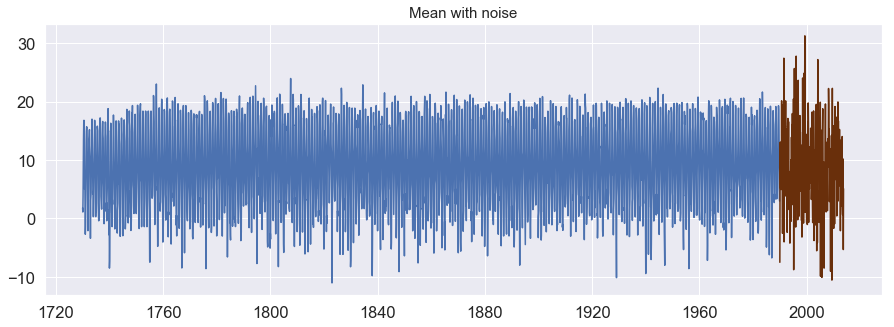

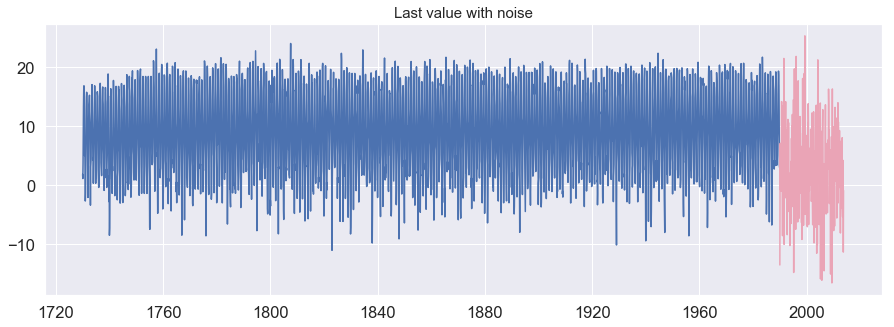

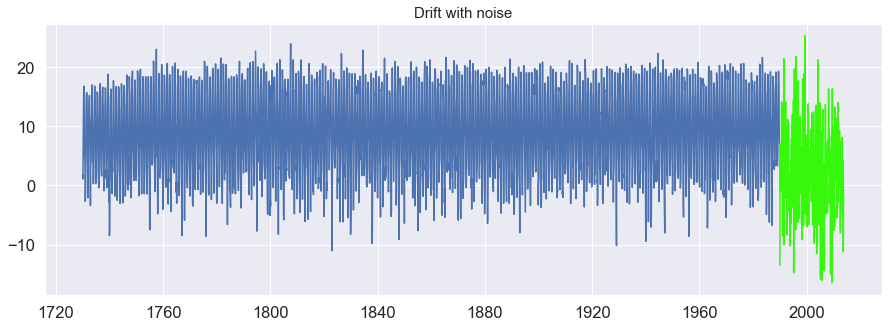

In [16]:
prediction = [pred1, pred2, pred3]
for i, j in enumerate(prediction):
    plt.figure(figsize=(15,5))
    plt.plot(train.index, train)
    plt.plot(test.index, j, color=np.random.rand(3,))
    if i==0:
        plt.title('Mean with noise', fontsize=15)
        plt.savefig('Baseline_mean.png')
    elif i==1:
        plt.title('Last value with noise', fontsize=15)
        plt.savefig('Baseline_last_values.png')
    else:
        plt.title('Drift with noise', fontsize=15)    
        plt.savefig('Baseline_drift.png')
sns.set(font_scale=1.5)

### 4.3 Decomposition with Statsmodel
Statsmodel 'additive' seasonal_decompose -> use to decompose data with negative or 0 values. 

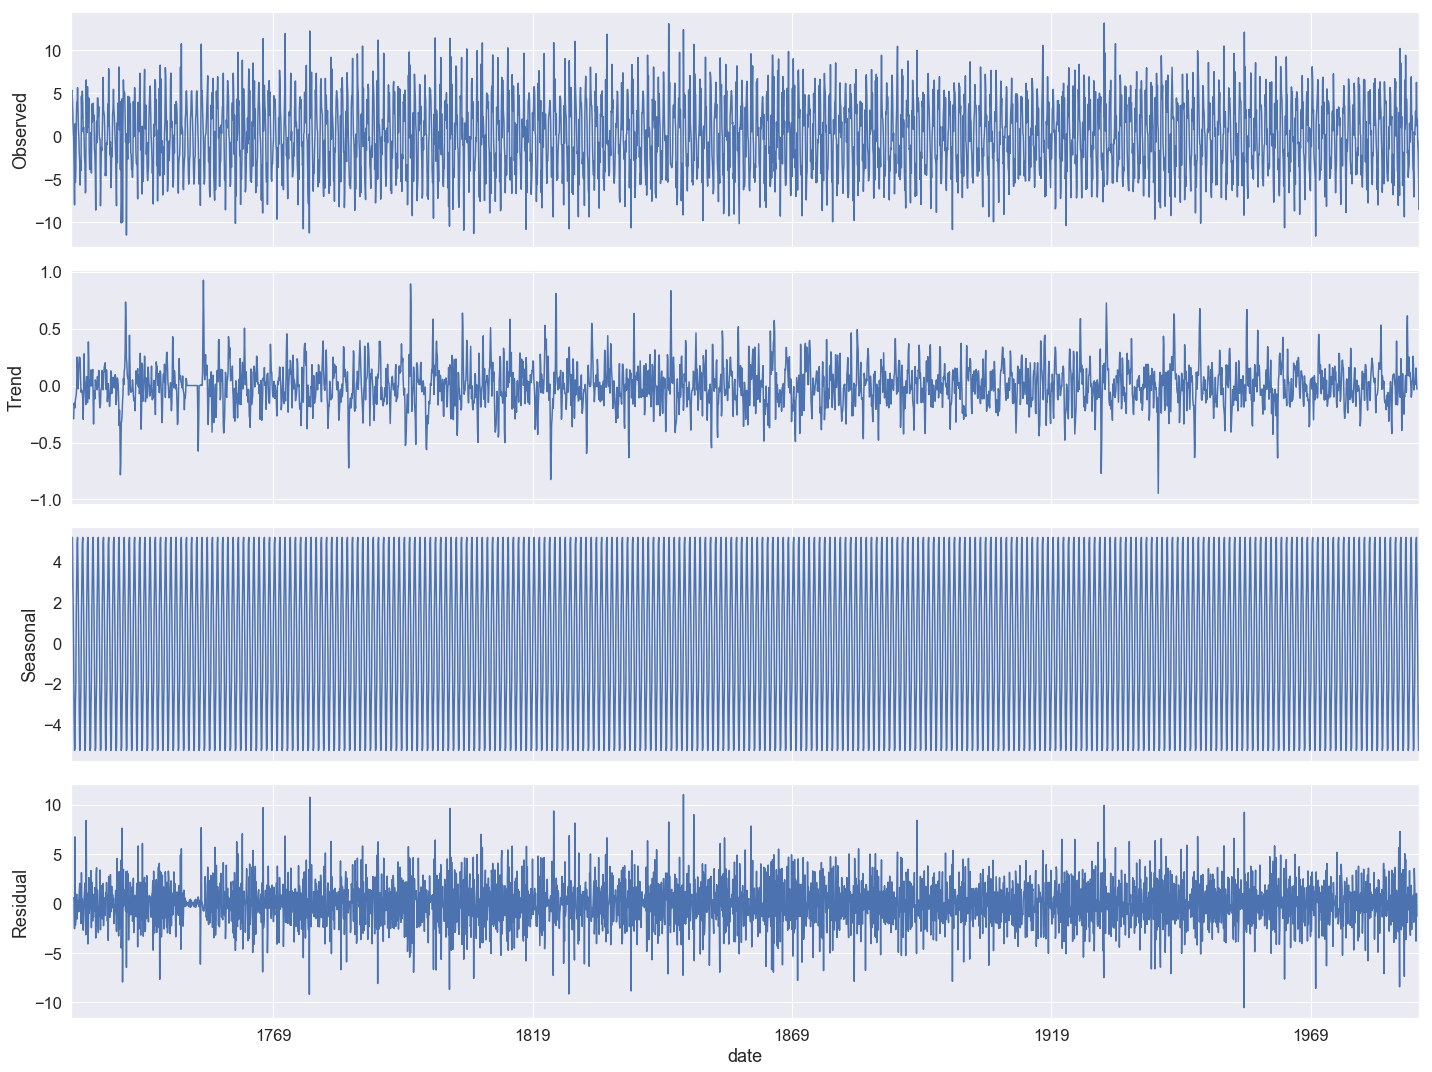

In [7]:
decompose = seasonal_decompose(train['adjust_temp'].diff().dropna(), model='additive')
plt.rc("figure", figsize=(20,15))
decompose.plot()
None

### 4.4 ARIMA

#### 4.4.1 Checking for autocorrelation
#### Unit root test with adfuller - if H0 rejected, our data is stationary
Arima requires stationary data (menaing that mean, variance and autocorrelation are all constant over time). If the data is non-stationary, the trend shall be removed before further analysis.

In [8]:
dftest = adfuller(decompose.resid.dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput.round(4))
# p-value < 0.05 => reject H0

Test Statistic                  -23.9219
p-value                           0.0000
Lags Used                        29.0000
Number of Observations Used    3077.0000
Critical Value (1%)              -3.4325
Critical Value (5%)              -2.8625
Critical Value (10%)             -2.5673
dtype: float64


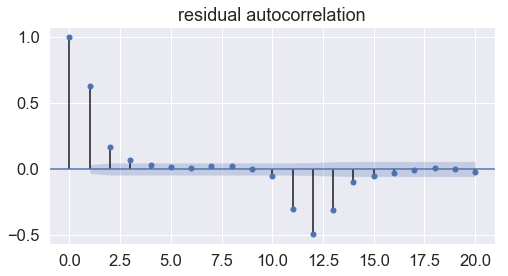

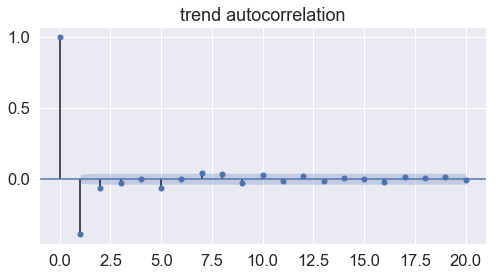

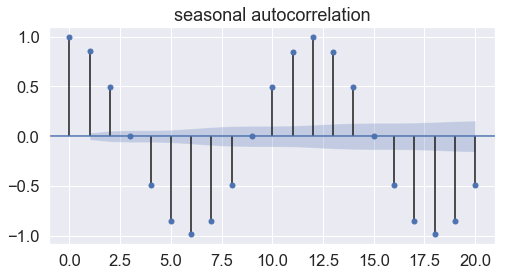

In [9]:
trend_stats = pd.DataFrame(decompose.trend).iloc[6:-6, :] 
resid_stats = pd.DataFrame(decompose.resid).iloc[6:-6, :] 
season_stats = pd.DataFrame(decompose.seasonal).iloc[6:-6, :] 

decomposition = [trend_stats, resid_stats, season_stats]
for i, j in enumerate(decomposition):
    plt.rc("figure", figsize=(8,4))
    plot_acf(j, lags=20)
    if i==0:
        plt.title('residual autocorrelation')
    elif i==1:
        plt.title('trend autocorrelation')
    else:
        plt.title('seasonal autocorrelation')
    plt.savefig(f'Autocorrelation_{i}.jpg')

# Plotting the autocorrelation -> the data shows clear seasonal pattern which is not surprising as it is climate data

### 4.5 SARIMAX
Use SARIMAX to add seasonality component to ARIMA.

<Figure size 576x288 with 0 Axes>

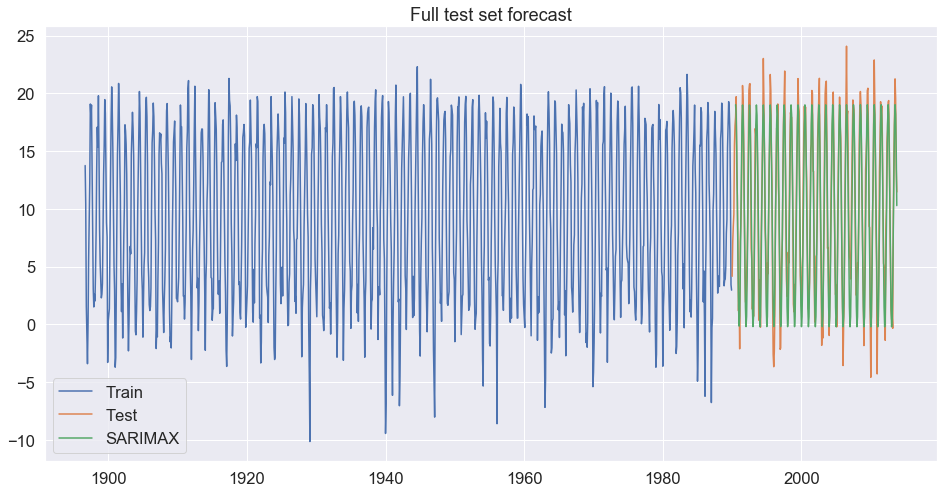

<Figure size 576x288 with 0 Axes>

In [15]:
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
pred = test.copy()
model = sm.tsa.statespace.SARIMAX(train.adjust_temp, 
                                 order=(2, 1, 6),
                                 seasonal_order=(0,0,1,12),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
result = model.fit()
forecast = result.forecast(steps = 24)
pred['SARIMAX'] = result.predict(start="1990-07-1", end="2013-10-01")
plt.figure(figsize=(16,8))
plt.plot(train.iloc[2000:, :], label='Train')
plt.plot(test['adjust_temp'], label='Test')
plt.plot(pred['SARIMAX'], label='SARIMAX')
plt.legend(loc='best')
plt.title('Full test set forecast')
plt.figure('Forecast.png')

<Figure size 576x288 with 0 Axes>

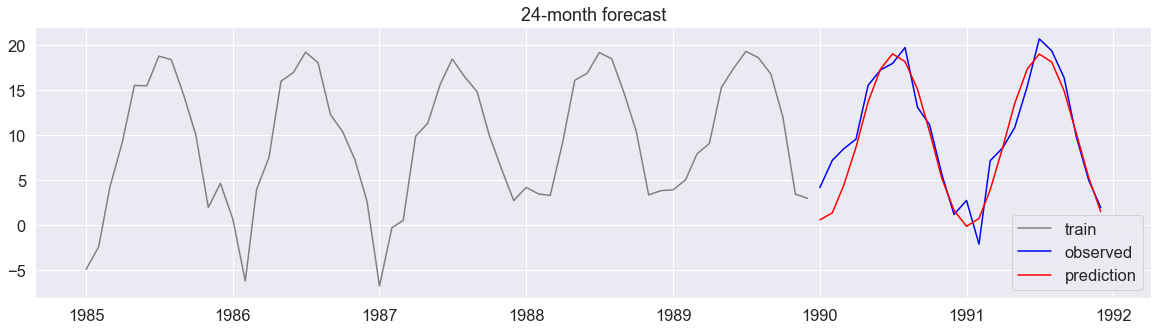

<Figure size 576x288 with 0 Axes>

In [11]:
f5 = plt.figure(figsize=(20,5))
plt.plot(train.iloc[3060:, :].index, train.iloc[3060:, :].adjust_temp, color='grey', label='train') 
plt.plot(test.iloc[0:24, :].index, test.iloc[0:24, :].adjust_temp, color='blue', label='observed')
plt.plot(forecast.index, forecast, color='red', label='prediction') 
plt.title('24-month forecast')
plt.legend(loc='best')
plt.figure('Forecast_2years.png')

### 4.6 Prediction quality
Calculating model error for SARIMAX compared to the best perfoming baseline model

In [12]:
def model_accuracy(test_data, prediction):
    print(f'''MSE: {np.mean(np.square(test_data - prediction))}''')
    print(f'''MAE: {np.mean(np.abs(test_data - prediction))}\n''')

In [13]:
print(f'Performance of the SARIMAX model: \n')
model_accuracy(test['adjust_temp'][6:].values, pred['SARIMAX'][6:].values)

print(f'Performance of the baseline model: \n')
model_accuracy(test.values, pred1.values)
# SARIMAX outperforms the baseline model

Performance of the SARIMAX model: 

MSE: 4.585865666371084
MAE: 1.7123799653719995

Performance of the baseline model: 

MSE: 103.04204759146162
MAE: 8.207410497080874

